In [1]:
from typing import Tuple
from IPython.display import Image as Im
from PIL import Image
from sklearn.cluster import KMeans
import numpy as np
import cv2
from scipy.spatial import Delaunay
from ultralytics import YOLO
from shapely import unary_union
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from scipy.ndimage import label
from src.clustering import (
    height_clustering,
    surface_clustering,
)

from src.regularization import (
    oriented_bounding_box,
    snap_to_grid,
    create_grid_cells,
    fill_grid_cells,
    convert_to_rectangles,
    find_intersections,
    create_grid_lines,
    scale_line,
    tin_grid_cells,
)
from src.create_polygons import (
    create_polygons,
    smoothed_mask,
    concat_masks,
    create_height_map,
    create_surface_map,
)
from src.line_extraction import (
    extract_intersection_lines,
    extract_step_lines,
)
from src.tin import (
    create_tin
)
from src.visualisation import (
    visualisation,
    vis_heatmap_and_mask,
    vis_heatmap_and_rgb,
    visualisation_lines,
    create_approximate_vis,
    all_visualisation,
)

from src.modified_contours import (
    apply_canny_to_mask,
    apply_canny,
    thin_contours_skeletonization,
    thin_contours,
)

### Материалы

Не забыть про то, что существует библиотека abspy https://github.com/chenzhaiyu/abspy

Библиотека на cpp https://github.com/tudelft3d/City3D

Что-то на питоне https://github.com/chrise96/3D_building_reconstruction

Еще одна статья про регуляризацию полигонов зданий https://www.mdpi.com/2220-9964/12/12/469

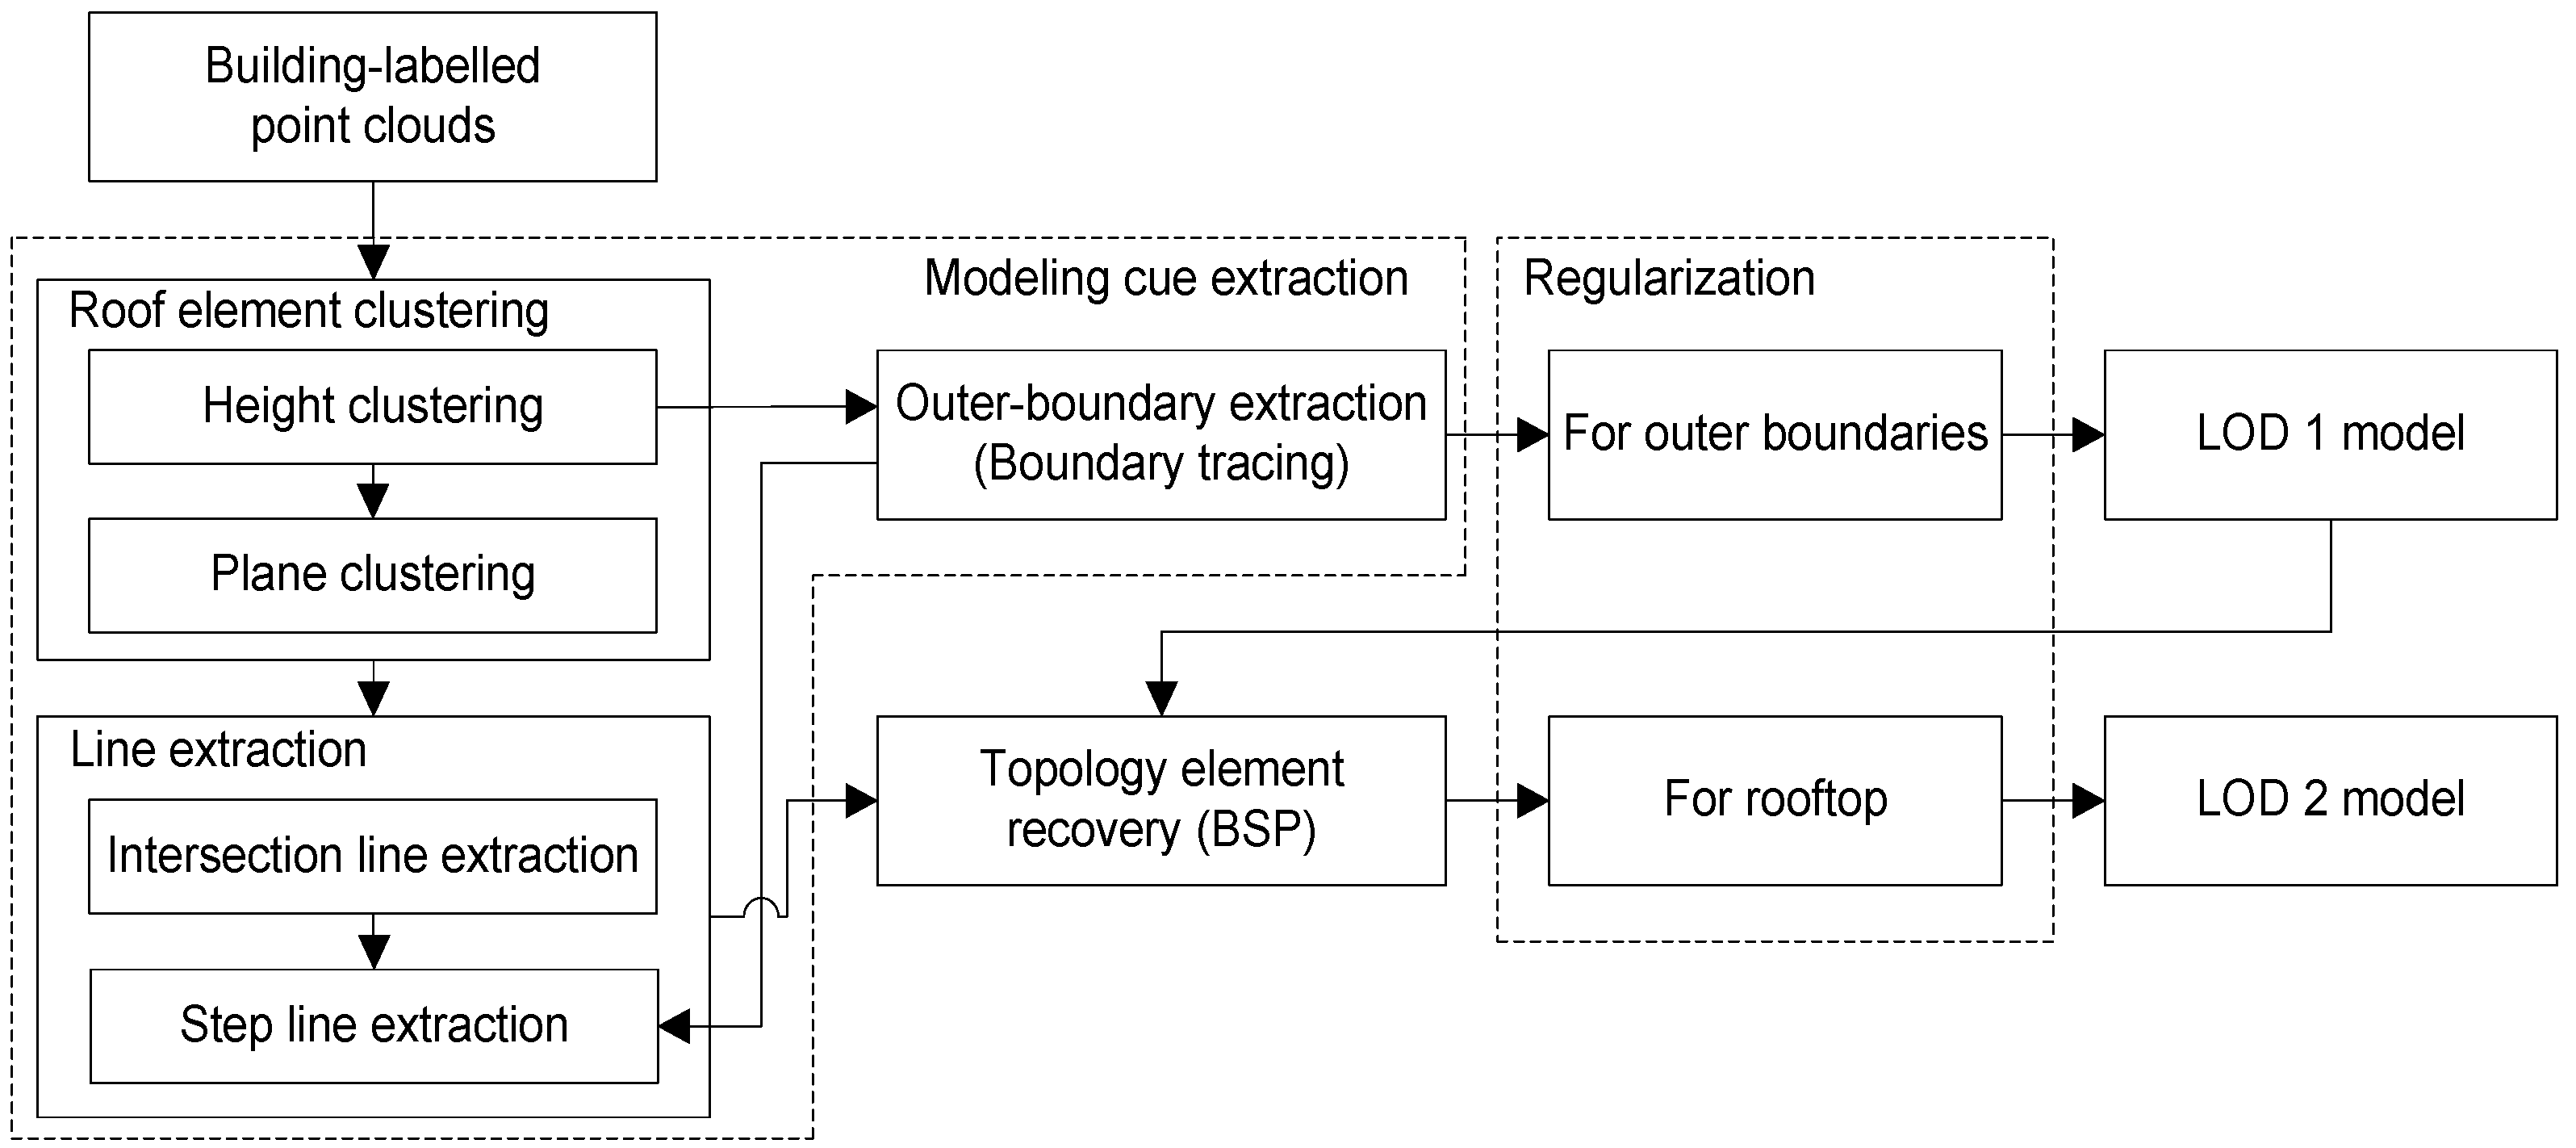

In [2]:
Im(filename='../images/sensors-17-00621-g001.png', width=1000)

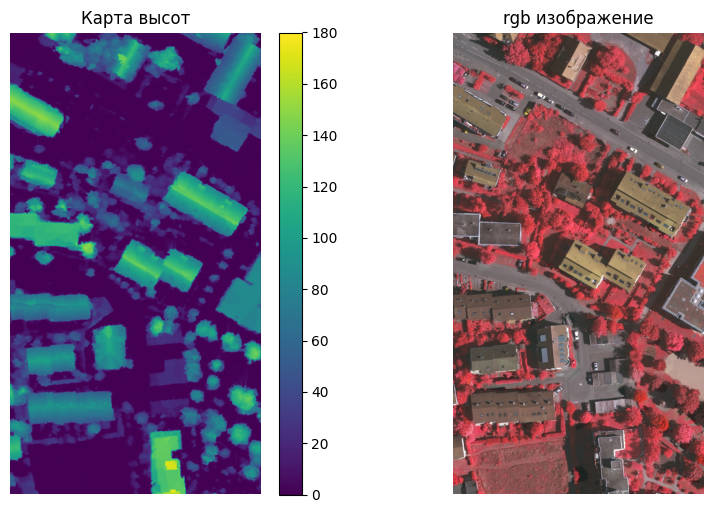

In [3]:
vai: str = '../../../shared_data/datasets/Vaihingen/train/NDSM/area34.tif'
vai_rgb: str = '../../../shared_data/datasets/Vaihingen/train/RGB/area34.tif'
image = Image.open(vai_rgb)
vis_heatmap_and_rgb(vai, vai_rgb)

## Instance mask + Canny + find_contours

In [4]:
heatmap = Image.open(vai)
image = Image.open(vai_rgb)
model = YOLO('../../../shared_data/users/avlasov/vaihingen.pt')
result = model(image)


0: 1024x576 28 buildingss, 65.4ms
Speed: 12.1ms preprocess, 65.4ms inference, 160.5ms postprocess per image at shape (1, 3, 1024, 576)


(np.float64(-0.5), np.float64(245.5), np.float64(249.5), np.float64(-0.5))

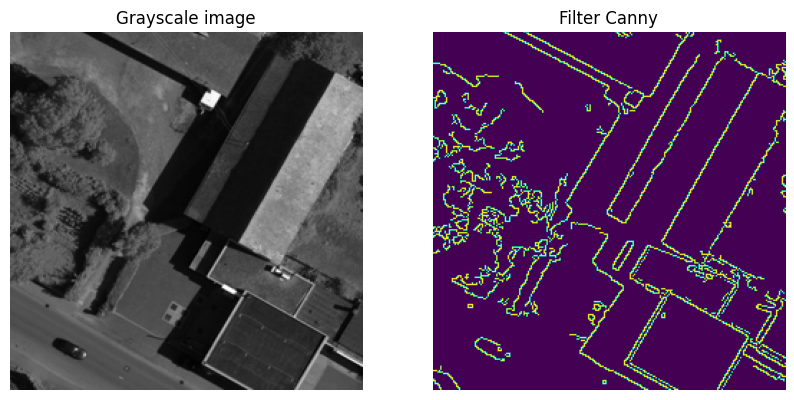

In [5]:
image = Image.open("../../../shared_data/datasets/Vaihingen/train/RGB/area34.tif")
heatmap = Image.open('../../../shared_data/datasets/Vaihingen/train/NDSM/area34.tif')
instance_mask = np.asarray(result[0].masks.data[10].cpu()[:250,330:])
heatmap = heatmap.resize((576, 1024))
heatmap_array = np.array(heatmap)[:250,330:]
image = image.resize((576, 1024))
img_array = np.array(image.convert('L'))[:250,330:]
edges = cv2.Canny(img_array, 100, 200)

_, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(img_array, cmap='gray')
axes[0].set(title='Grayscale image')
axes[0].axis('off')
axes[1].imshow(edges)
axes[1].set(title='Filter Canny')
axes[1].axis('off')

In [6]:
cropped_image = np.array(image)[:250,330:]
edges = apply_canny_to_mask(cropped_image, np.asarray(instance_mask).astype(np.uint8))
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed_edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

thin_edges = thin_contours_skeletonization(closed_edges)

(np.float64(-0.5), np.float64(245.5), np.float64(249.5), np.float64(-0.5))

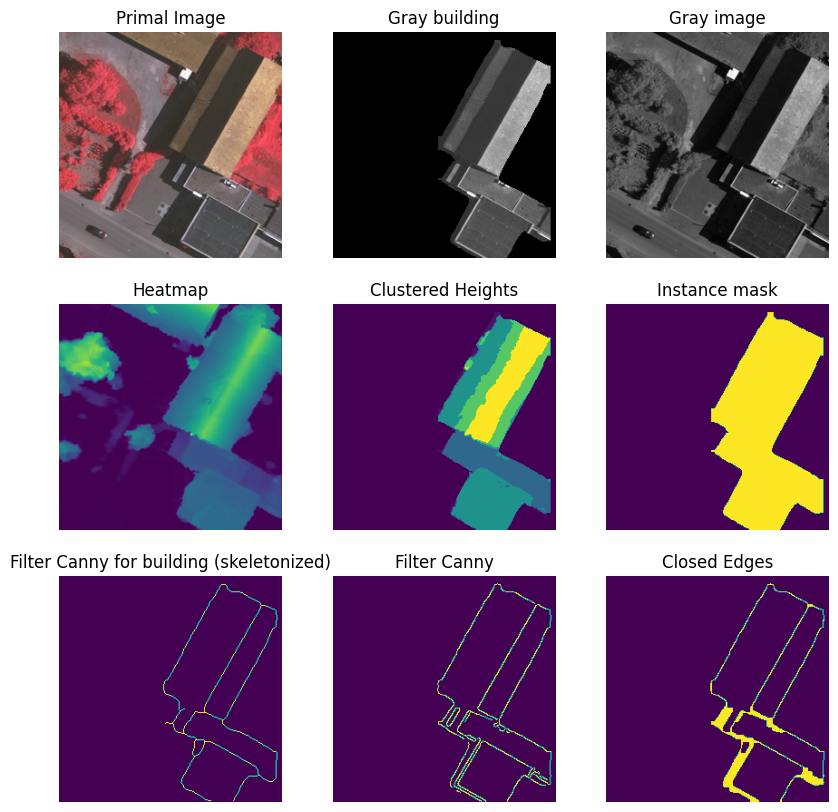

In [7]:
mask = np.expand_dims(instance_mask.astype(np.float32), axis=-1) * cropped_image.astype(np.float32)
mask_edges = apply_canny(mask)
gray_image = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
gray_mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
clustered_heights_building = height_clustering(heatmap_array, instance_mask)
clustered_heights_building[clustered_heights_building == 17] = 0

_, axes = plt.subplots(3, 3, figsize=(10, 10))
axes[0][0].imshow(np.array(image)[:250,330:, :])
axes[0][0].set(title='Primal Image')
axes[0][0].axis('off')
axes[0][1].imshow(gray_mask, cmap='gray')
axes[0][1].set(title='Gray building')
axes[0][1].axis('off')
axes[0][2].imshow(gray_image, cmap='gray')
axes[0][2].set(title='Gray image')
axes[0][2].axis('off')
axes[1][0].imshow(heatmap_array)
axes[1][0].set(title='Heatmap')
axes[1][0].axis('off')
axes[1][1].imshow(clustered_heights_building)
axes[1][1].set(title='Clustered Heights')
axes[1][1].axis('off')
axes[1][2].imshow(instance_mask)
axes[1][2].set(title='Instance mask')
axes[1][2].axis('off')
axes[2][0].imshow(thin_edges)
axes[2][0].set(title='Filter Canny for building (skeletonized)')
axes[2][0].axis('off')
axes[2][1].imshow(edges)
axes[2][1].set(title='Filter Canny')
axes[2][1].axis('off')
axes[2][2].imshow(closed_edges)
axes[2][2].set(title='Closed Edges')
axes[2][2].axis('off')

In [8]:
surface_mask = label(~thin_edges[:245, :])[0]
surface_mask[surface_mask == 0] = 1
print(np.unique(surface_mask))

[1 2 3 4 5 6]


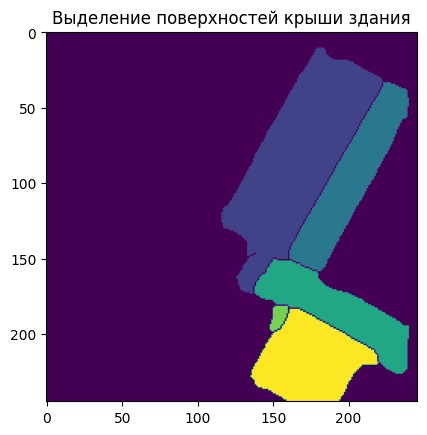

In [9]:
plt.figure()
plt.imshow(surface_mask)
plt.title('Выделение поверхностей крыши здания')
plt.show()

In [10]:
from skimage.measure import find_contours
rng = np.unique(surface_mask)

contour_samples: dict = {}

for instance in rng[1:]:
    contour_samples[int(instance)] = find_contours((surface_mask == instance))

In [11]:
r_contours: dict = {}

for k, v in contour_samples.items():
    building_polygon = Polygon(contour_samples[k][0])
    # Вычисление bounding box
    bbox, rotation_matrix, min_point, max_point = oriented_bounding_box(building_polygon)

    # Подравнивание полигона с сеткой
    resolution: float = 3.0  # Разрешение сетки
    snapped_polygon, snapped_coords = snap_to_grid(building_polygon, resolution)

    # Создание сетки внутри bounding box
    h_lines, v_lines = create_grid_lines(min_point, max_point, rotation_matrix, resolution)
    # Коэффициент увеличения (например, на 5%)
    scale_factor: float = 1.05
    # Масштабируем линии
    scaled_h_lines = np.array([scale_line(line, scale_factor) for line in h_lines])
    scaled_v_lines = np.array([scale_line(line, scale_factor) for line in v_lines])

    intersections = find_intersections(scaled_h_lines, scaled_v_lines)

    minipolygons = tin_grid_cells(intersections)
    if int(k) == 3:
        example_poly = building_polygon
        example_mini = minipolygons

    r_contours[k] = unary_union(fill_grid_cells(building_polygon, minipolygons))

In [12]:
mapp = create_surface_map(r_contours)

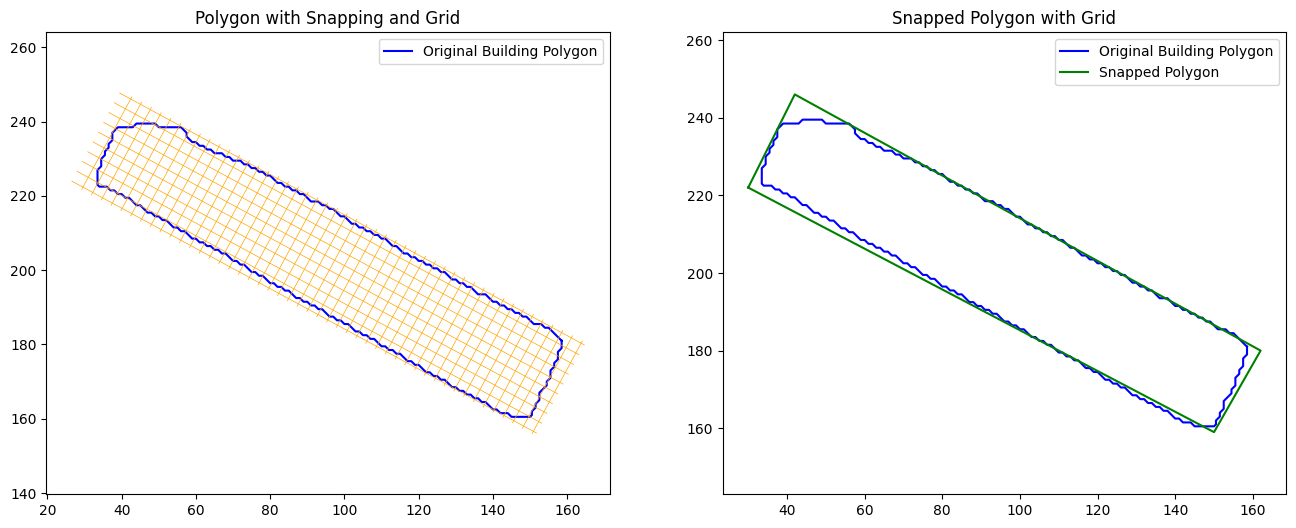

In [13]:
building_polygon = Polygon(contour_samples[3][0])
# Вычисление bounding box
bbox, rotation_matrix, min_point, max_point = oriented_bounding_box(building_polygon)

# Подравнивание полигона с сеткой
resolution: float = 3.0  # Разрешение сетки
snapped_polygon, snapped_coords = snap_to_grid(building_polygon, resolution)

# Создание сетки внутри bounding box
h_lines, v_lines = create_grid_lines(min_point, max_point, rotation_matrix, resolution)

# Коэффициент увеличения (например, на 5%)
scale_factor: float = 1.05
# Масштабируем линии
scaled_h_lines = np.array([scale_line(line, scale_factor) for line in h_lines])
scaled_v_lines = np.array([scale_line(line, scale_factor) for line in v_lines])

intersections = find_intersections(scaled_h_lines, scaled_v_lines)

# Выполняем Delaunay триангуляцию
points = intersections
tri = Delaunay(points)

# Создаем список миниполигонов
minipolygons: list = []
for simplex in tri.simplices:
    poly_points = points[simplex]  # Получаем точки треугольника
    polygon = Polygon(poly_points)  # Создаем полигон из точек
    minipolygons.append(polygon)

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Полигоны и сетка
axes[0].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
# axes[0].plot(bbox[:, 0], bbox[:, 1], label="Oriented Bounding Box", color="red")
for line in scaled_h_lines:
    axes[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
for line in scaled_v_lines:
    axes[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
axes[0].set_title("Polygon with Snapping and Grid")
axes[0].axis("equal")
axes[0].legend()

# График 2: Полигоны без сетки
axes[1].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
axes[1].plot(*snapped_polygon.exterior.xy, label="Snapped Polygon", color="green")

axes[1].set_title("Snapped Polygon with Grid")
axes[1].axis("equal")
axes[1].legend()

plt.show()

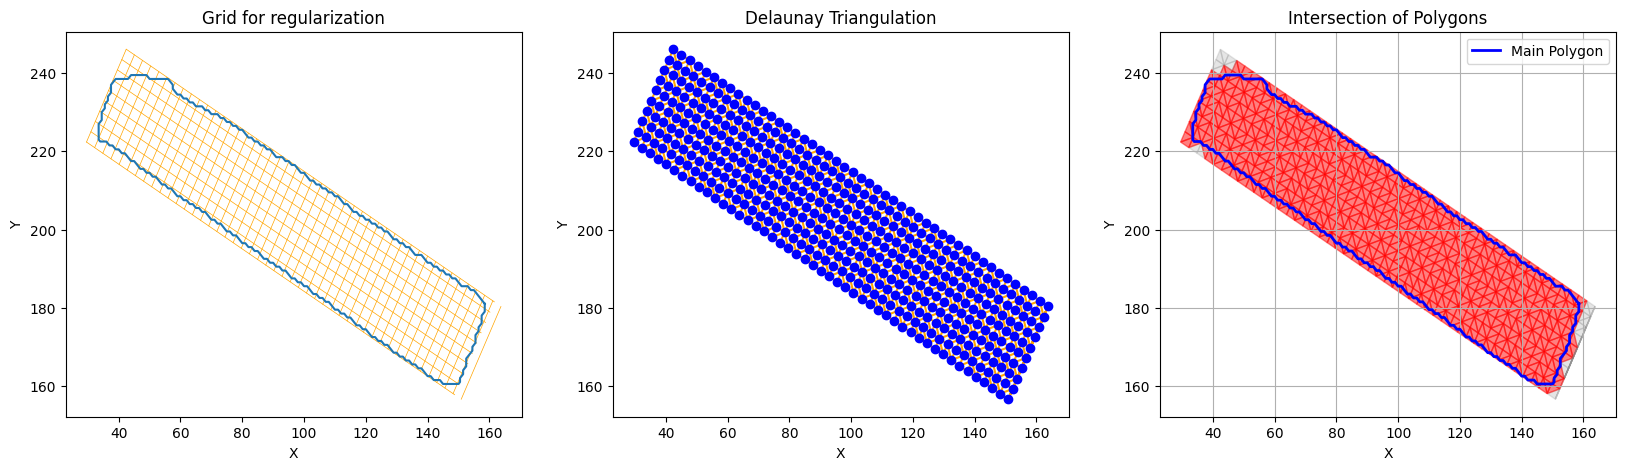

In [18]:
# Визуализация
fig, ax = plt.subplots(1, 3, figsize=(20,5))

for line in h_lines:
    ax[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
for line in v_lines:
    ax[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
ax[0].plot(*example_poly.exterior.xy)
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].set_title('Grid for regularization')
# Отрисовка миниполигонов
ax[1].triplot(points[:, 0], points[:, 1], tri.simplices, color='orange')
ax[1].plot(points[:, 0], points[:, 1], 'o', color='blue')

ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].set_title('Delaunay Triangulation')

for mini_poly in example_mini:
    x, y = mini_poly.exterior.xy
    if example_poly.intersects(mini_poly):  # Проверка на пересечение
        ax[2].fill(x, y, color='red', alpha=0.5)  # Закрашиваем, если пересекаются
    else:
        ax[2].fill(x, y, color='gray', alpha=0.2)  # Иначе полупрозрачный серый

# Отрисовка основного полигона
x, y = example_poly.exterior.xy
ax[2].plot(x, y, color='blue', linewidth=2, label="Main Polygon")

ax[2].set_xlabel('X')
ax[2].set_ylabel('Y')
ax[2].set_title('Intersection of Polygons')
ax[2].legend()
ax[2].grid(True)

plt.show()

In [16]:
contours_dict_new: dict = {}
resolution: float = 2.0
for key, values in contour_samples.items():
    contours: list = []
    for value in values:
        building_polygon = Polygon(value)
        
        # Создание сетки
        grid_cells = create_grid_cells(building_polygon, resolution)

        # Заполнение ячеек сетки
        filled_cells = fill_grid_cells(building_polygon, grid_cells)
        contours.append(unary_union(filled_cells))
    contours_dict_new[key] = contours

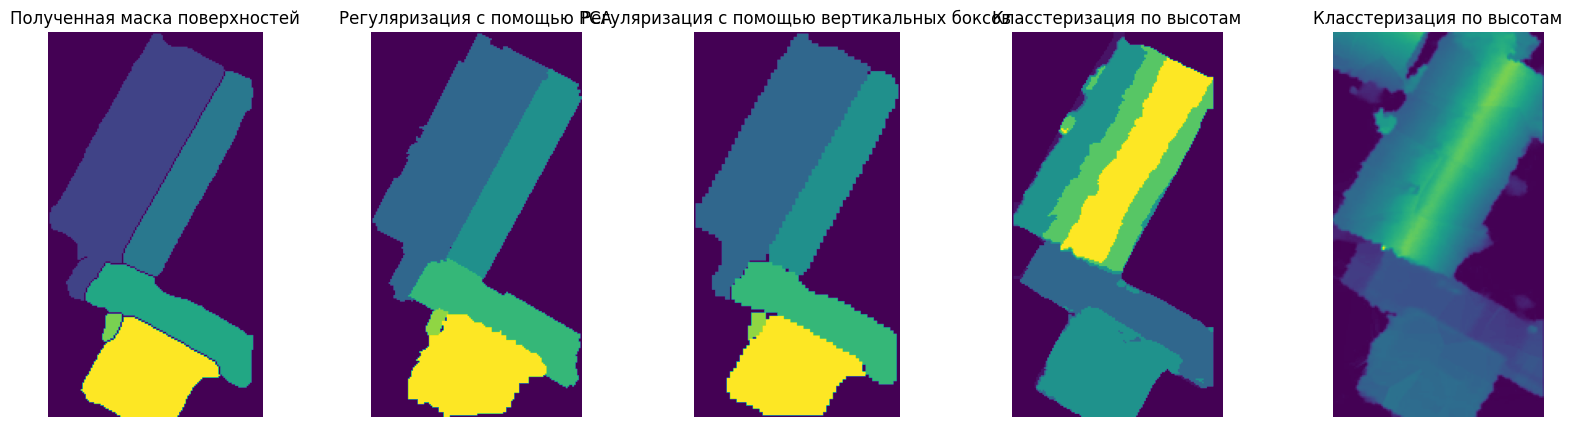

In [51]:
rect_map = create_height_map(contours_dict_new, resolution=1)

x = 115
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
axs[0].imshow(surface_mask[10:, x:x + 131])
axs[0].set_title('Полученная маска поверхностей')
axs[0].axis('off')
axs[1].imshow(mapp.T)
axs[1].set_title('Регуляризация с помощью PCA')
axs[1].axis('off')
axs[2].imshow(rect_map.T)
axs[2].set_title('Регуляризация с помощью вертикальных боксов')
axs[2].axis('off')
axs[3].imshow(clustered_heights_building[10:, x:x + 131])
axs[3].set_title('Класстеризация по высотам')
axs[3].axis('off')
axs[4].imshow(heatmap_array[10:, x:x + 131])
axs[4].set_title('Класстеризация по высотам')
axs[4].axis('off')
plt.show()

In [52]:
exp_height = heatmap_array[10:, x:x + 131]
exp_surf = mapp.T

In [ ]:
import numpy as np

def detect_flat_surfaces(surface_matrix, height_matrix, flatness_threshold=3):
    """
    Определяет плоские и неровные поверхности по разбросу высот внутри каждой области.

    :param surface_matrix: 2D numpy массив, где указаны номера областей
    :param height_matrix: 2D numpy массив, где указаны значения высот
    :param flatness_threshold: Порог отклонения, ниже которого поверхность считается плоской
    :return: Список номеров плоских и неровных поверхностей
    """
    unique_surfaces = np.unique(surface_matrix)
    flat_surfaces = []
    rough_surfaces = []

    for surface_id in unique_surfaces:
        # Создание маски для текущей поверхности
        mask = surface_matrix == surface_id
        heights = height_matrix[mask]

        if heights.size == 0:
            continue

        # Вычисление статистик высоты
        min_height = np.min(heights)
        max_height = np.max(heights)
        height_range = max_height - min_height  # Размах высот
        std_dev = np.std(heights)  # Стандартное отклонение
        median_height = np.median(heights)

        # Использование межквартильного размаха (IQR) для поиска выбросов
        q1, q3 = np.percentile(heights, [25, 75])
        iqr = q3 - q1

        # Определение "плоскости" по стандартному отклонению и IQR
        if height_range < flatness_threshold * median_height and std_dev < flatness_threshold and iqr < flatness_threshold:
            flat_surfaces.append(surface_id)
        else:
            rough_surfaces.append(surface_id)

    return flat_surfaces, rough_surfaces

# Использование функции
flat_surfaces, rough_surfaces = detect_flat_surfaces(exp_surf, exp_height, flatness_threshold=10)

print(f"Плоские поверхности: {flat_surfaces}")
print(f"Неровные поверхности: {rough_surfaces}")


Плоские поверхности: [np.float64(4.0), np.float64(5.0), np.float64(6.0)]
Неровные поверхности: [np.float64(0.0), np.float64(2.0), np.float64(3.0)]


In [91]:
flat_surfaces

[np.float64(4.0), np.float64(5.0), np.float64(6.0)]

In [95]:
building_map: np.ndarray = exp_height * np.where(exp_surf == 0, 0, 1)
for surf in flat_surfaces:
    building_map = np.where(building_map == surf, np.mean(building_map[exp_surf == surf]), building_map)

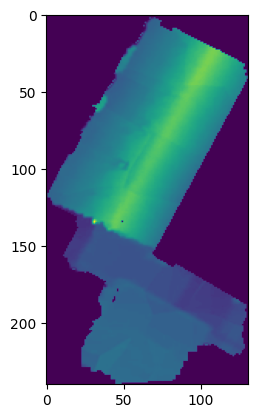

In [97]:
plt.imshow(building_map)

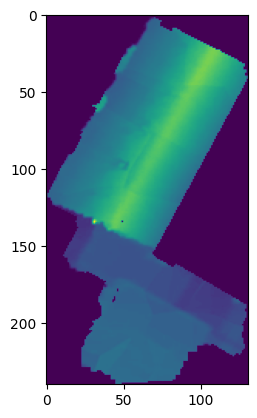

In [90]:
plt.imshow(building_map)

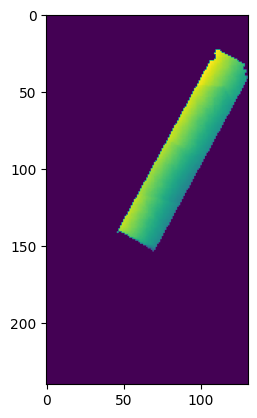

In [92]:

plt.imshow(exp_height * np.where(mapp.T == 3, 1, 0))

## Запуск кода и визуализация кластеризации по высотам и поверхностям

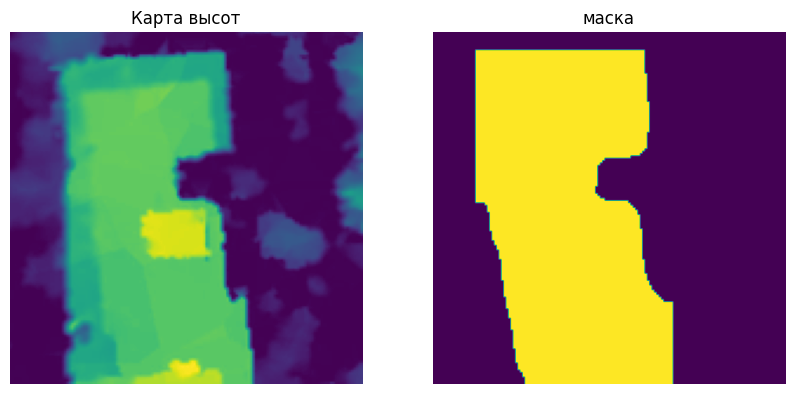

In [5]:
heatmap_resize = np.array(heatmap.resize((576, 1024)))
house_map = heatmap_resize[874:,300:450]
house = np.asarray(result[0].masks.data[7].cpu()[874:,300:450])
vis_heatmap_and_mask(house_map, house)

Высоты кластеров

Есть идея разбить абсолютно все объекты на контуры и проходить по ним дугласом

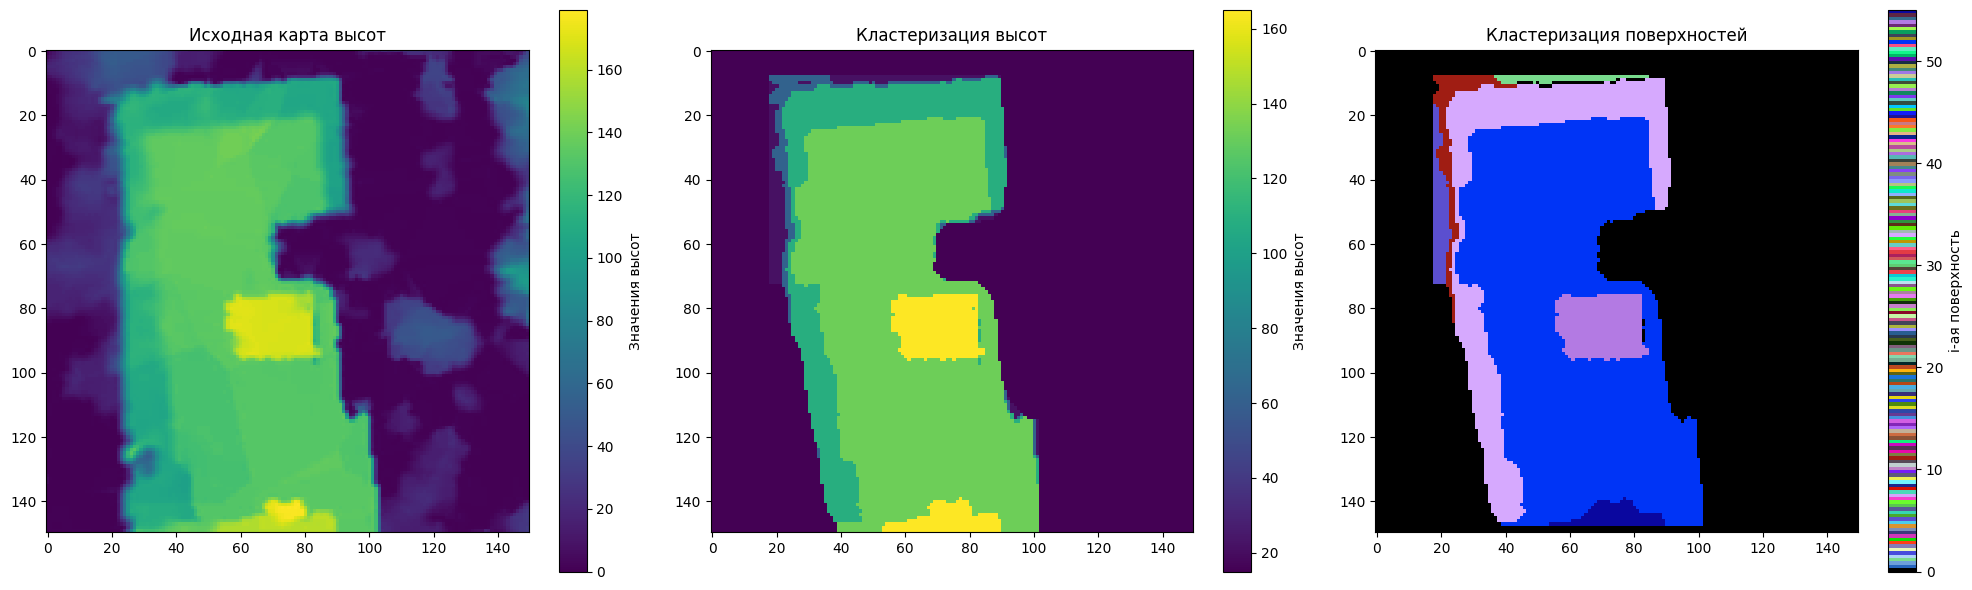

In [6]:
clustered_heights_building = height_clustering(house_map, house)
instance_masks = surface_clustering(clustered_heights_building)
all_masks = concat_masks(instance_masks)
clustered_surfaces_building = smoothed_mask(all_masks, min_size_objects=40, interations=2)
visualisation(house_map, clustered_heights_building, clustered_surfaces_building)
contours_dict = create_polygons(instance_masks, tolerance=1)

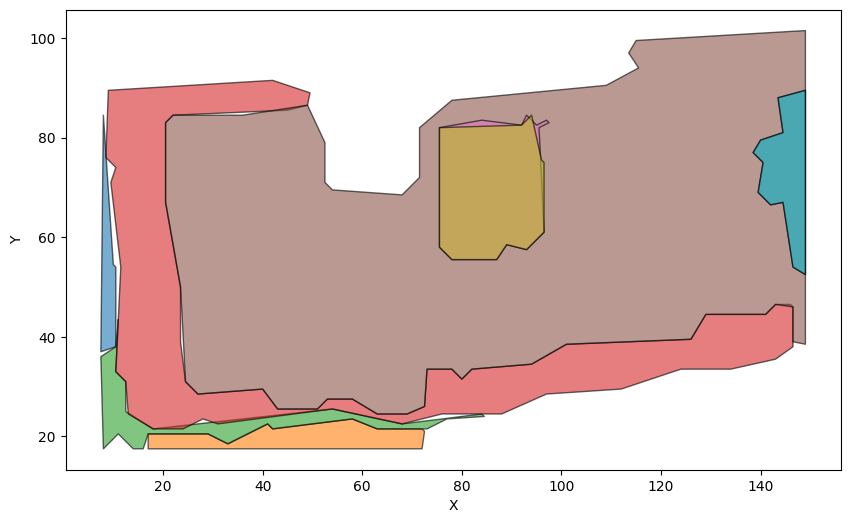

In [7]:
create_approximate_vis(contours_dict)

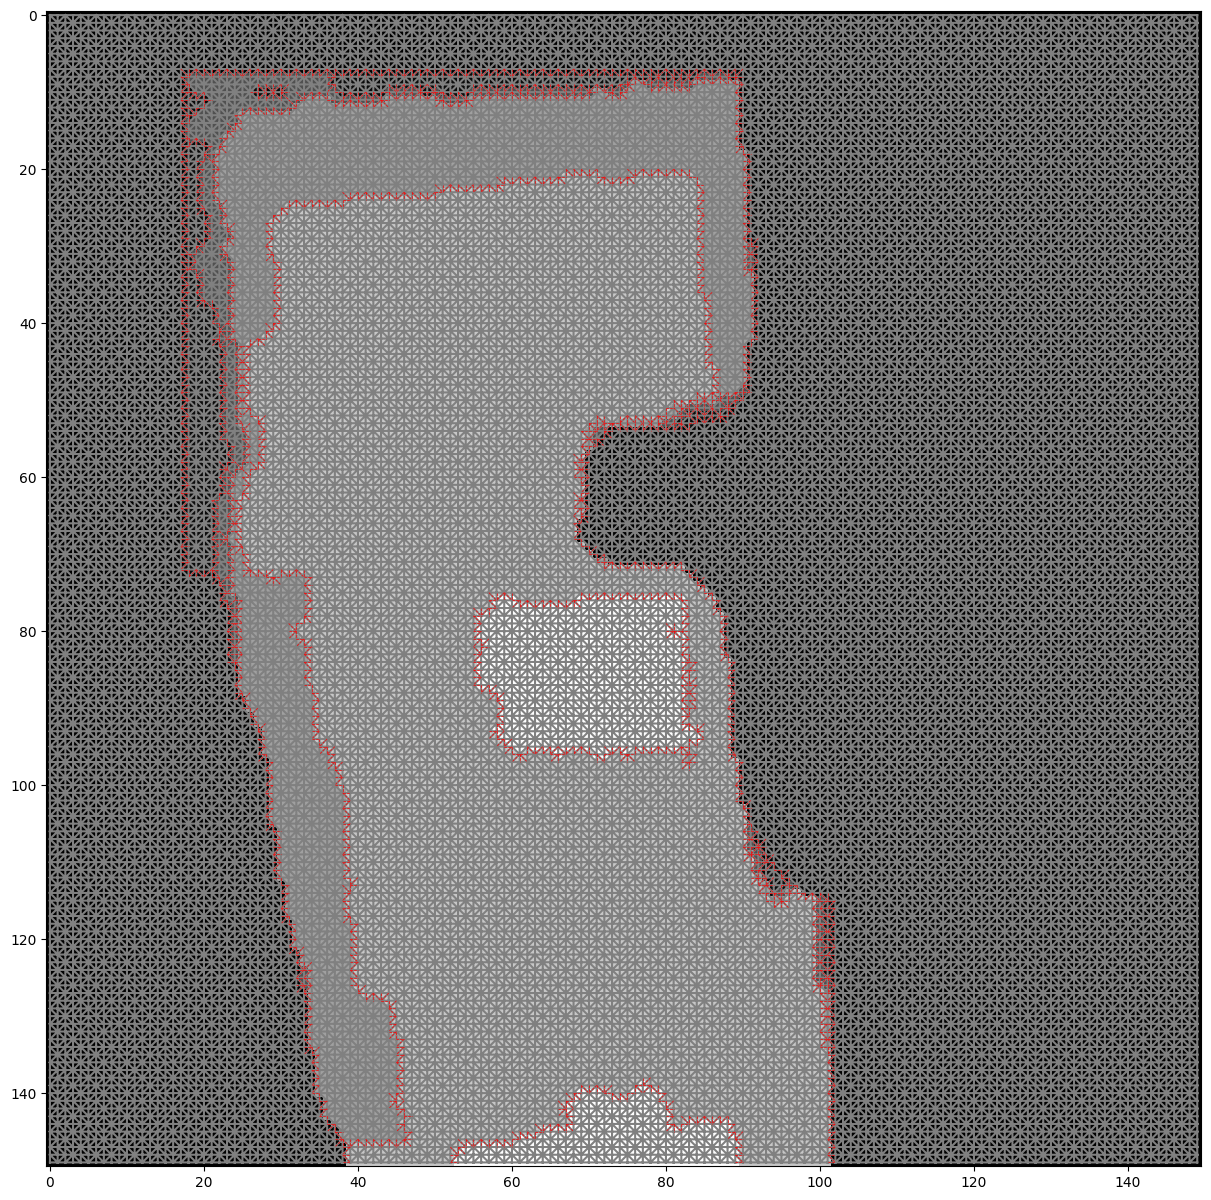

In [8]:
points, triangulation = create_tin(clustered_heights_building)
intersection_lines = extract_intersection_lines(triangulation, clustered_heights_building)
visualisation_lines(points, triangulation, clustered_heights_building, intersection_lines)

###  Алгоритм упрощения и регуляризации для контуров зданий из прямоугольников с неровными краями

Статья: https://www.mdpi.com/2220-9964/12/12/469

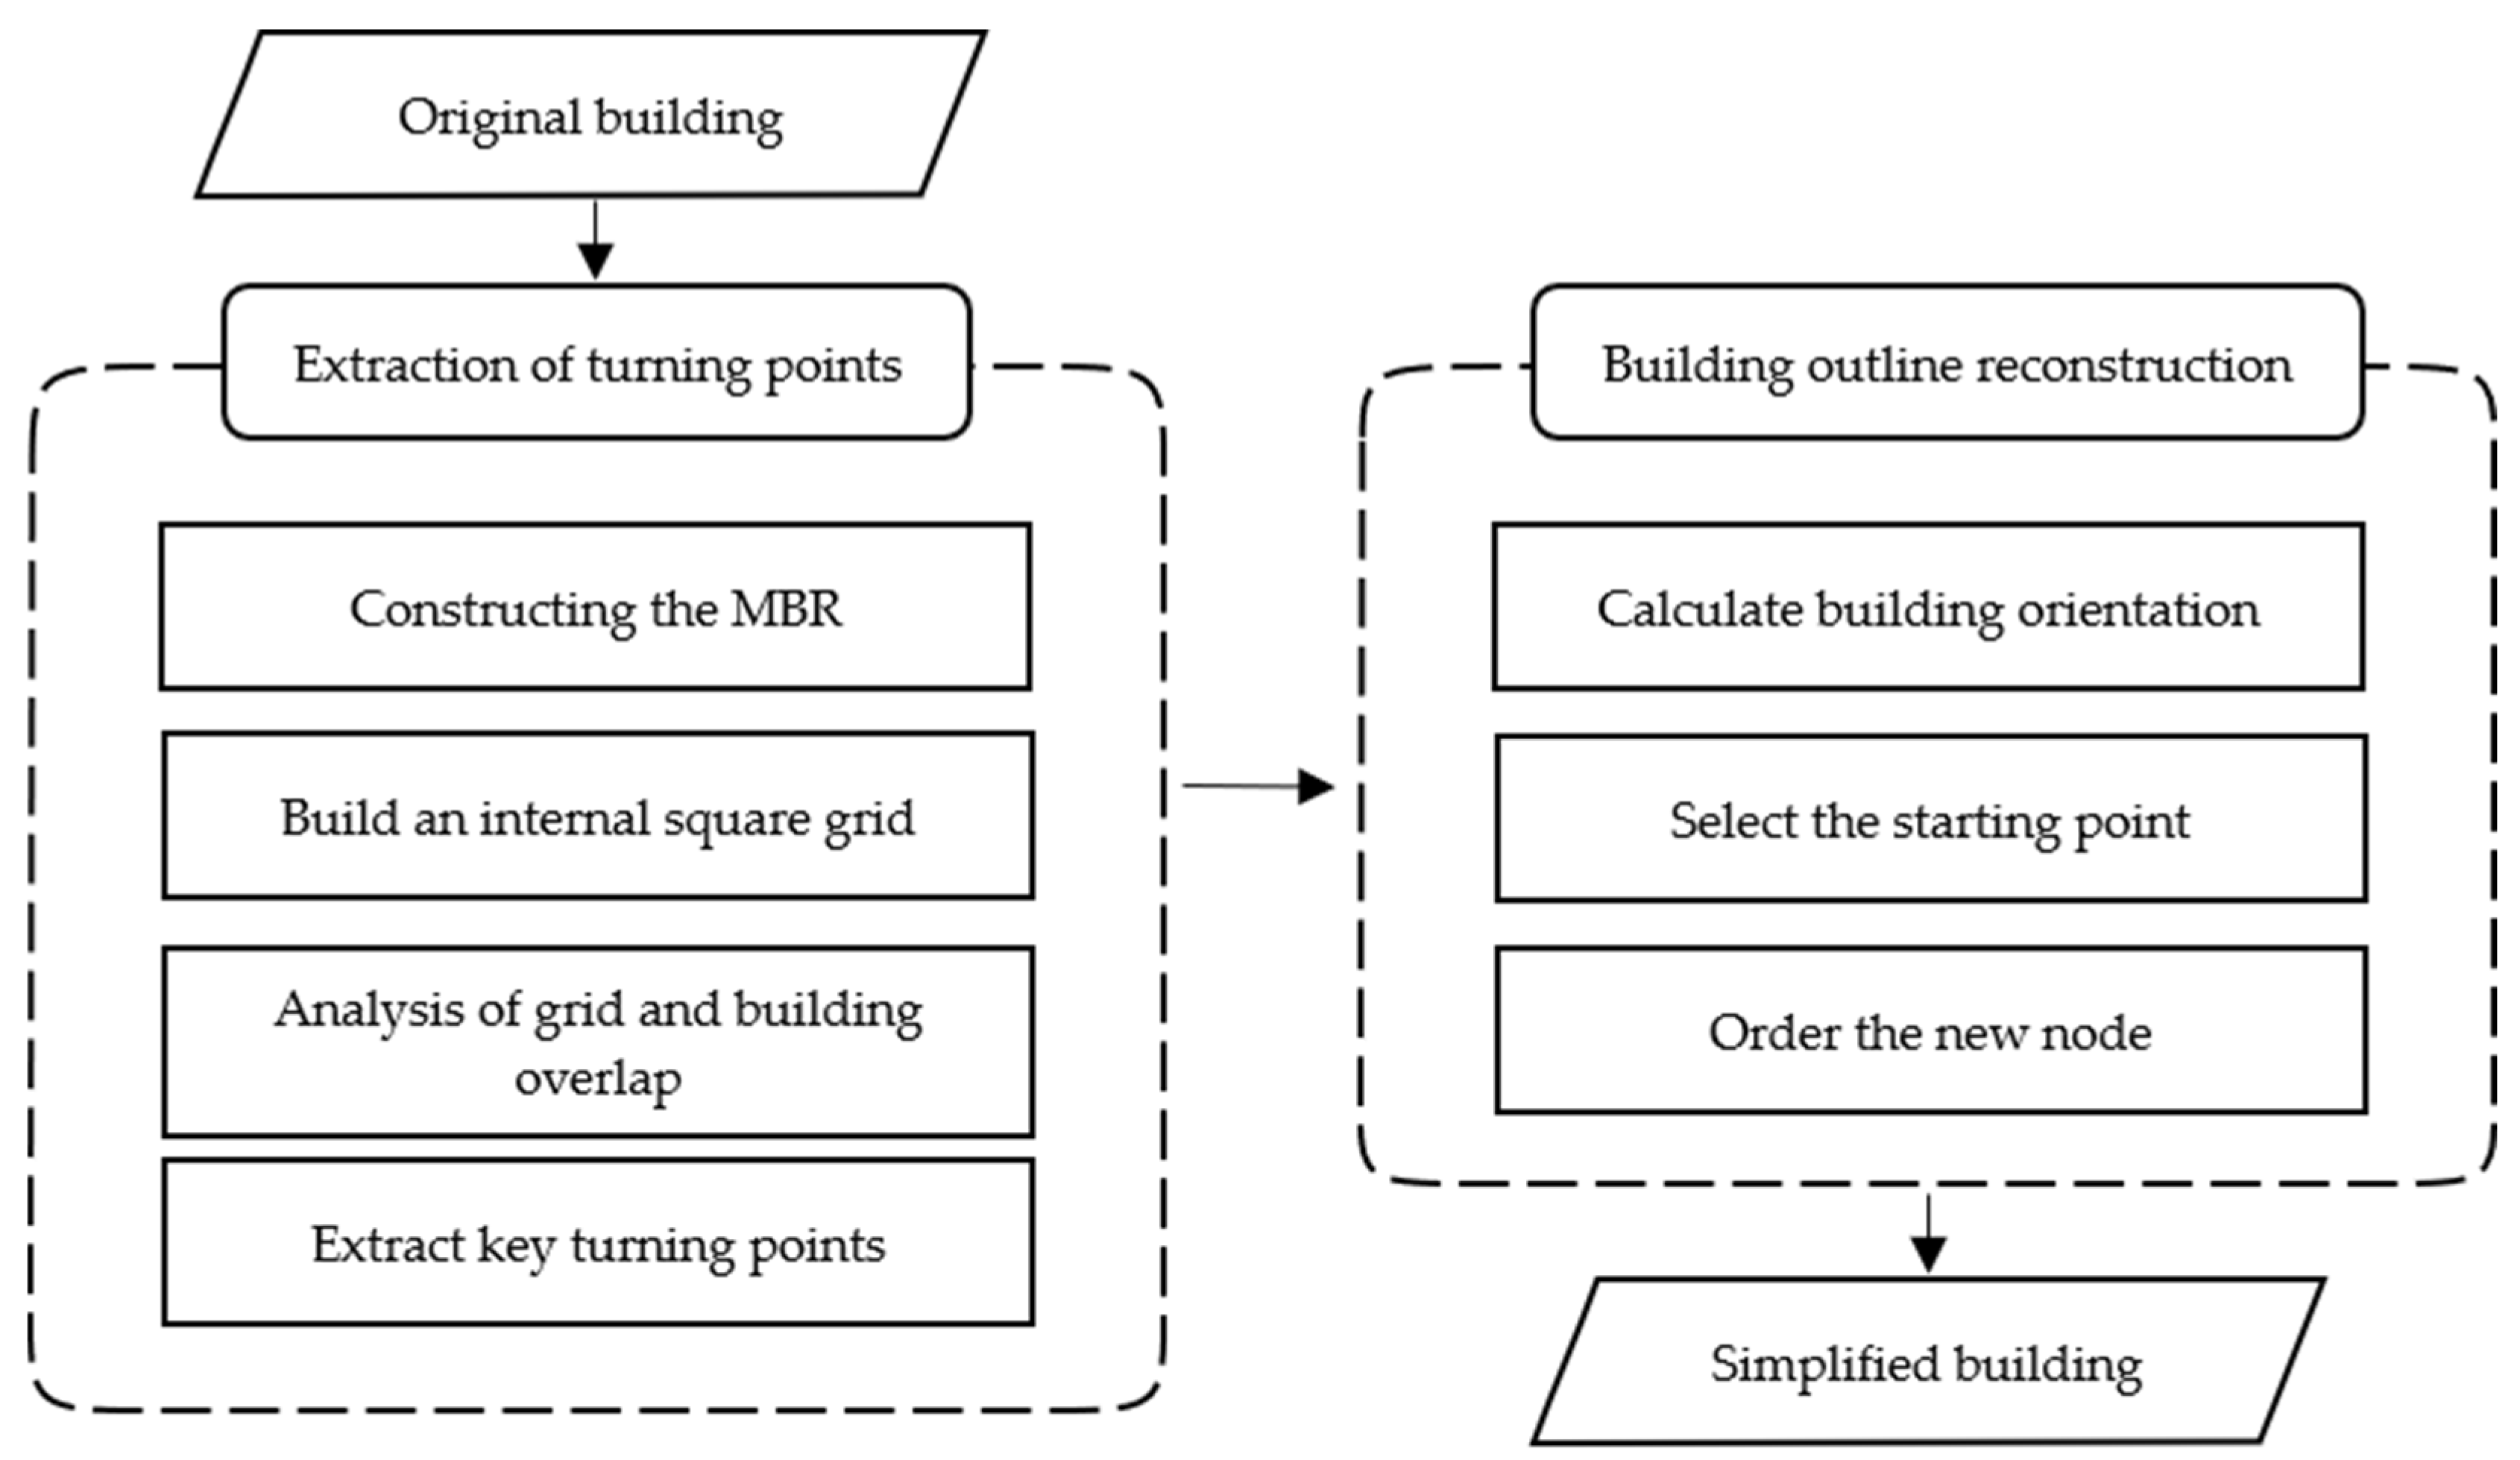

In [9]:
Im('../images/ijgi-12-00469-g002.png', width=1000)

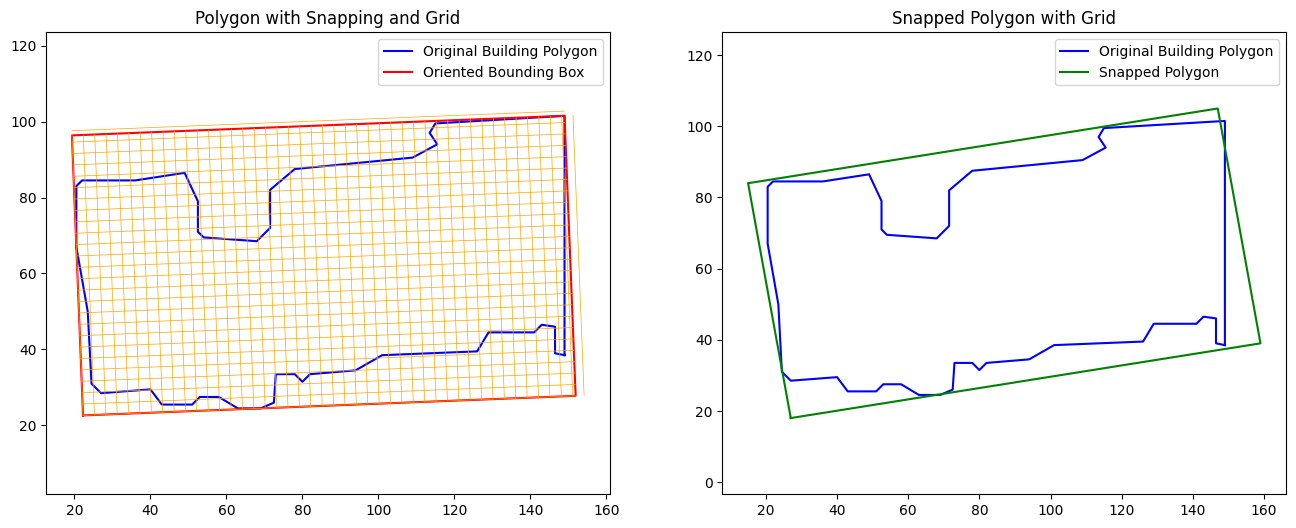

In [10]:
def create_grid_lines(min_point, max_point, rotation_matrix, resolution):
    """
    Создает линии сетки внутри повернутого bounding box.
    
    :param min_point: Минимальные координаты (min_x, min_y) повернутого bounding box
    :param max_point: Максимальные координаты (max_x, max_y) повернутого bounding box
    :param rotation_matrix: Матрица поворота bounding box
    :param resolution: Шаг сетки
    :return: Горизонтальные и вертикальные линии в исходной системе координат
    """
    min_x, min_y = min_point
    max_x, max_y = max_point

    # Горизонтальные линии
    y_coords = np.arange(min_y, max_y + resolution, resolution)
    horizontal_lines = [
        [[min_x, y], [max_x, y]] for y in y_coords
    ]

    # Вертикальные линии
    x_coords = np.arange(min_x, max_x + resolution, resolution)
    vertical_lines = [
        [[x, min_y], [x, max_y]] for x in x_coords
    ]

    # Объединяем линии
    all_lines_rotated = np.array(horizontal_lines + vertical_lines)

    # Обратный поворот линий в исходное пространство
    all_lines_original = []
    for line in all_lines_rotated:
        transformed_line = line @ rotation_matrix
        all_lines_original.append(transformed_line)

    return np.array(all_lines_original)


building_polygon = Polygon(contours_dict[132][0])

# Вычисление bounding box
bbox, rotation_matrix, min_point, max_point = oriented_bounding_box(building_polygon)

# Подравнивание полигона с сеткой
resolution = 3.0  # Разрешение сетки
snapped_polygon, snapped_coords = snap_to_grid(building_polygon, resolution)

# Создание сетки внутри bounding box
grid_lines = create_grid_lines(min_point, max_point, rotation_matrix, resolution)


# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График 1: Полигоны и сетка
axes[0].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
axes[0].plot(bbox[:, 0], bbox[:, 1], label="Oriented Bounding Box", color="red")
for line in grid_lines:
    axes[0].plot(line[:, 0], line[:, 1], color="orange", linewidth=0.5)
axes[0].set_title("Polygon with Snapping and Grid")
axes[0].axis("equal")
axes[0].legend()

# График 2: Полигоны без сетки
axes[1].plot(*building_polygon.exterior.xy, label="Original Building Polygon", color="blue")
axes[1].plot(*snapped_polygon.exterior.xy, label="Snapped Polygon", color="green")

axes[1].set_title("Snapped Polygon with Grid")
axes[1].axis("equal")
axes[1].legend()

plt.show()

Лучше использовать Snapped, основанный на MBR, чем Oriented, основанный на PCA. Он дает более приближенное мажоритарное направление полигона части здания. 
Но также в shapely есть метод minimum_rotated_rectangle, который вроде как делает то же самое

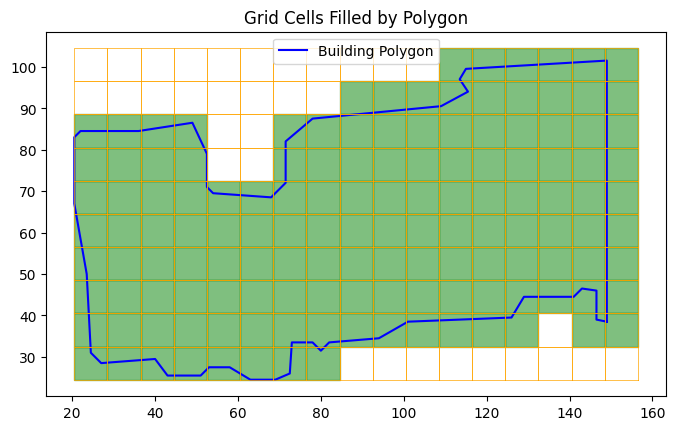

In [ ]:
# Пример использования

# Полигон здания
building_polygon = Polygon(contours_dict[132][0])

# Разрешение сетки
resolution = 8.0  # Размер ячеек

# Создание сетки
grid_cells = create_grid_cells(building_polygon, resolution)

# Заполнение ячеек сетки
filled_cells = fill_grid_cells(building_polygon, grid_cells, resolution)

# Визуализация
fig, ax = plt.subplots(figsize=(8, 6))

# Отображение исходного полигона
x, y = building_polygon.exterior.xy
ax.plot(x, y, label="Building Polygon", color="blue")

# Отображение заполненных ячеек
for cell in filled_cells:
    x, y = cell.exterior.xy
    ax.fill(x, y, color="green", alpha=0.5)
# Отображение всех ячеек сетки
for cell in grid_cells:
    x, y = cell.exterior.xy
    ax.plot(x, y, color="orange", linewidth=0.5)
ax.set_title("Grid Cells Filled by Polygon")
ax.set_aspect("equal")
ax.legend()

plt.show()

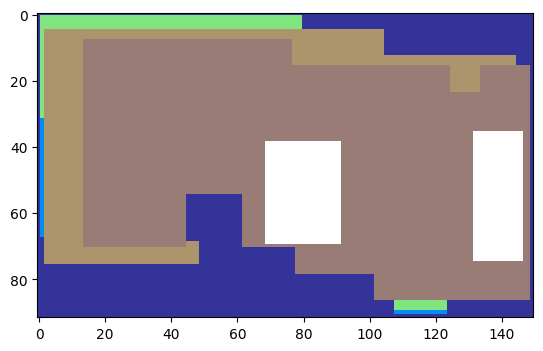

In [12]:
contours_dict_new = convert_to_rectangles(contours_dict, resolution=8.0)
height_map = create_height_map(contours_dict_new, resolution=1)
plt.imshow(height_map, cmap='terrain')


Text(0, 0.5, 'Y')

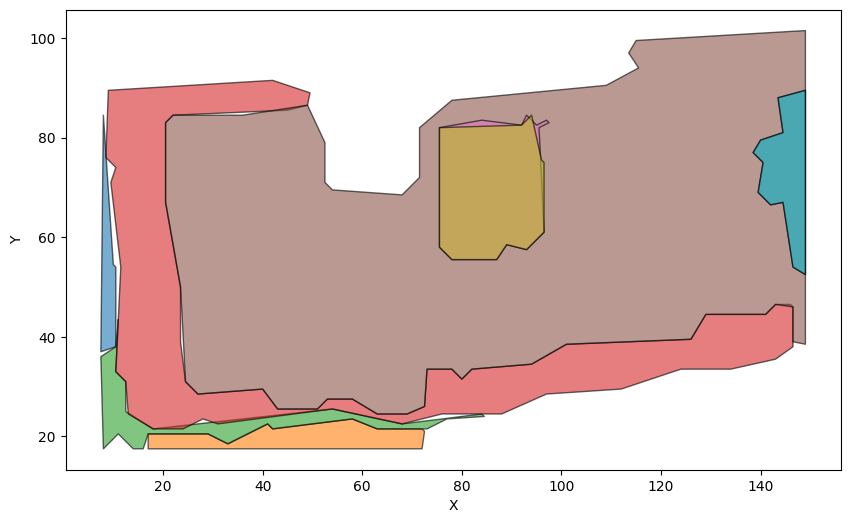

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as Poly
from matplotlib.collections import PatchCollection
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(10, 8))

# Цветовая палитра
colors = plt.cm.tab10.colors  # Выбираем палитру
area_threshold: int = 20
# Итерация по словарю
patches = []
for _, polygons in contours_dict.items():
    for polygon in polygons:

        # Проверяем площадь полигона
        if Polygon(polygon).area < area_threshold:
            continue  # Пропускаем слишком маленькие полигоны
        poly_patch = Poly(polygon, closed=True)
        patches.append(poly_patch)

# Добавляем коллекцию полигонов с цветами
collection = PatchCollection(patches, cmap='tab10', edgecolor='black', alpha=0.6)
collection.set_array(np.arange(len(patches)))  # Установка индекса цветов

ax.add_collection(collection)

# Настройка осей
ax.autoscale_view()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')

Text(0, 0.5, 'Y')

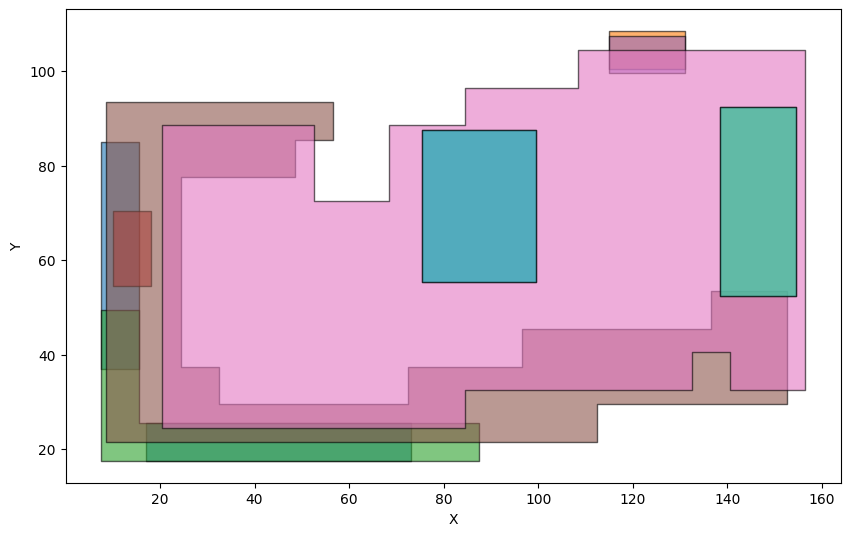

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as Poly
from matplotlib.collections import PatchCollection
from shapely.geometry import MultiPolygon
# Создание фигуры и осей
fig, ax = plt.subplots(figsize=(10, 8))

# Цветовая палитра
colors = plt.cm.tab10.colors  # Выбираем палитру
area_threshold: int = 100
# Итерация по словарю
patches = []
for _, polygons in contours_dict_new.items():
    for polygon in polygons:
        if polygon.is_empty:
            continue

        # Проверяем площадь полигона
        if polygon.area < area_threshold:
            continue  # Пропускаем слишком маленькие полигоны

        if isinstance(polygon, MultiPolygon):
            for poly in polygon.geoms:
                poly_patch = Poly(list(poly.exterior.coords), closed=True)
        else:
            poly_patch = Poly(list(polygon.exterior.coords), closed=True)

        patches.append(poly_patch)

# Добавляем коллекцию полигонов с цветами
collection = PatchCollection(patches, cmap='tab10', edgecolor='black', alpha=0.6)
collection.set_array(np.arange(len(patches)))  # Установка индекса цветов

ax.add_collection(collection)

# Настройка осей
ax.autoscale_view()
ax.set_aspect('equal', adjustable='box')
plt.xlabel('X')
plt.ylabel('Y')

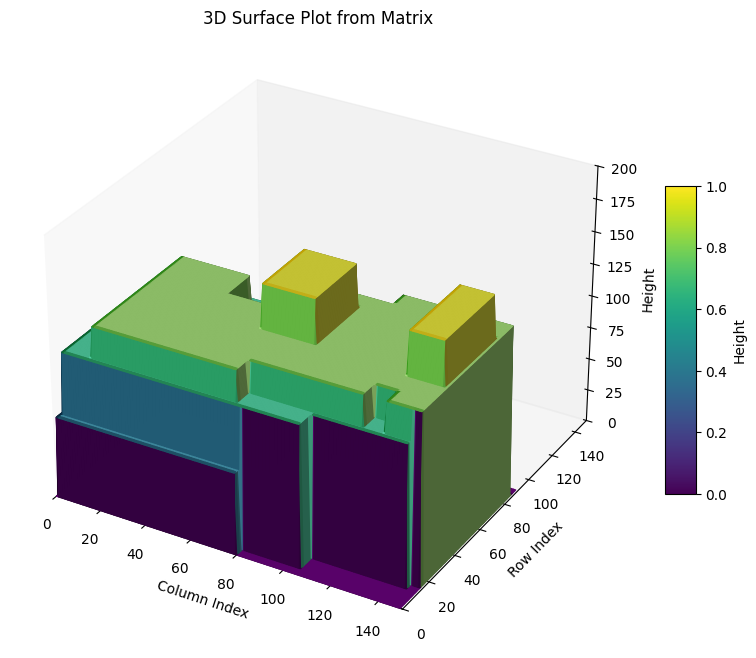

In [15]:
from matplotlib.colors import LightSource
def vis_3d_house(height_map: np.ndarray, shape: Tuple[int] = (150, 150, 200)) -> None:
    rows, cols = height_map.shape

    # Создаем координаты (x, y) для каждой точки
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection='3d')
    ls = LightSource(azdeg=100, altdeg=45)
    cmap = plt.cm.viridis
    rgb = ls.shade(height_map, cmap=cmap, blend_mode='soft')
    # Построение поверхности
    surf = ax.plot_surface(x, y, height_map, facecolors=rgb, rstride=1, cstride=1, antialiased=True)

    # Добавление шкалы значений
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
    cbar.set_label('Height')

    # Настройка осей
    ax.grid(False)
    ax.set_title("3D Surface Plot from Matrix")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    ax.set_zlabel("Height")
    ax.set_xlim3d(0, shape[0])
    ax.set_ylim3d(0, shape[1])
    ax.set_zlim3d(0, shape[2])

    plt.show()

vis_3d_house(height_map=height_map)

## Полномасштабная визуализация текущего этапа ресерча

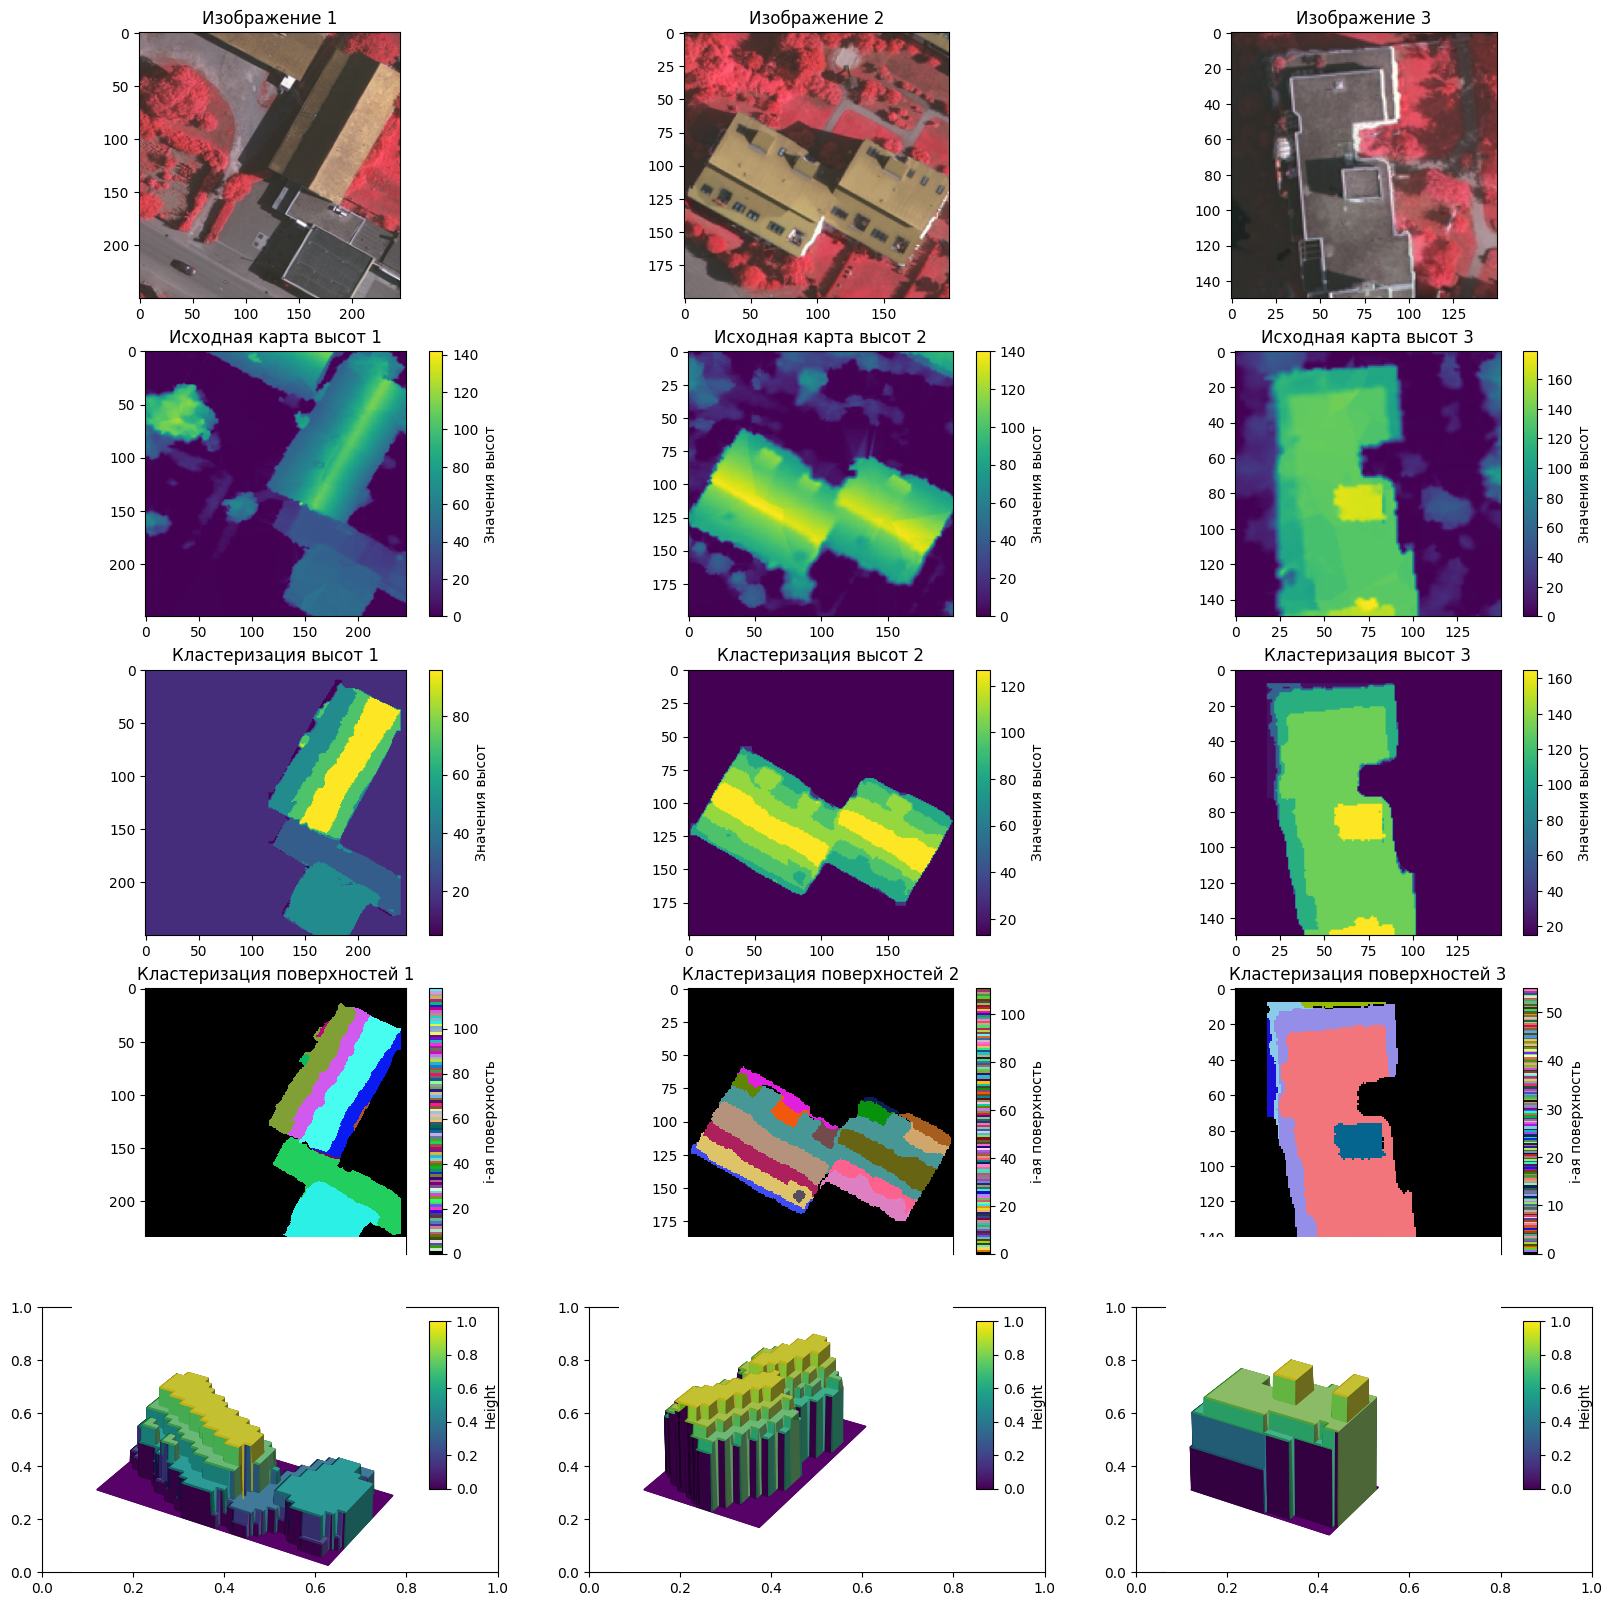

In [6]:
image_resize = image.resize((576, 1024))

crop_image_list = [
    np.array(image_resize)[:250,330:, :],
    np.array(image_resize)[400:600,240:440, :],
    np.array(image_resize)[874:,300:450, :],
]
instance_mask_list = [
    np.asarray(result[0].masks.data[10].cpu()[:250,330:]),
    np.asarray(result[0].masks.data[0].cpu()[400:600,240:440]),
    np.asarray(result[0].masks.data[7].cpu()[874:,300:450]),
]
house_map_list = [
    np.array(heatmap)[:250,330:],
    np.array(heatmap)[400:600,240:440],
    np.array(heatmap)[874:,300:450]
]
all_visualisation(
    crop_image_list=crop_image_list,
    house_map_list=house_map_list,
    instance_mask_list=instance_mask_list,

)

## Старые визуализации сцен

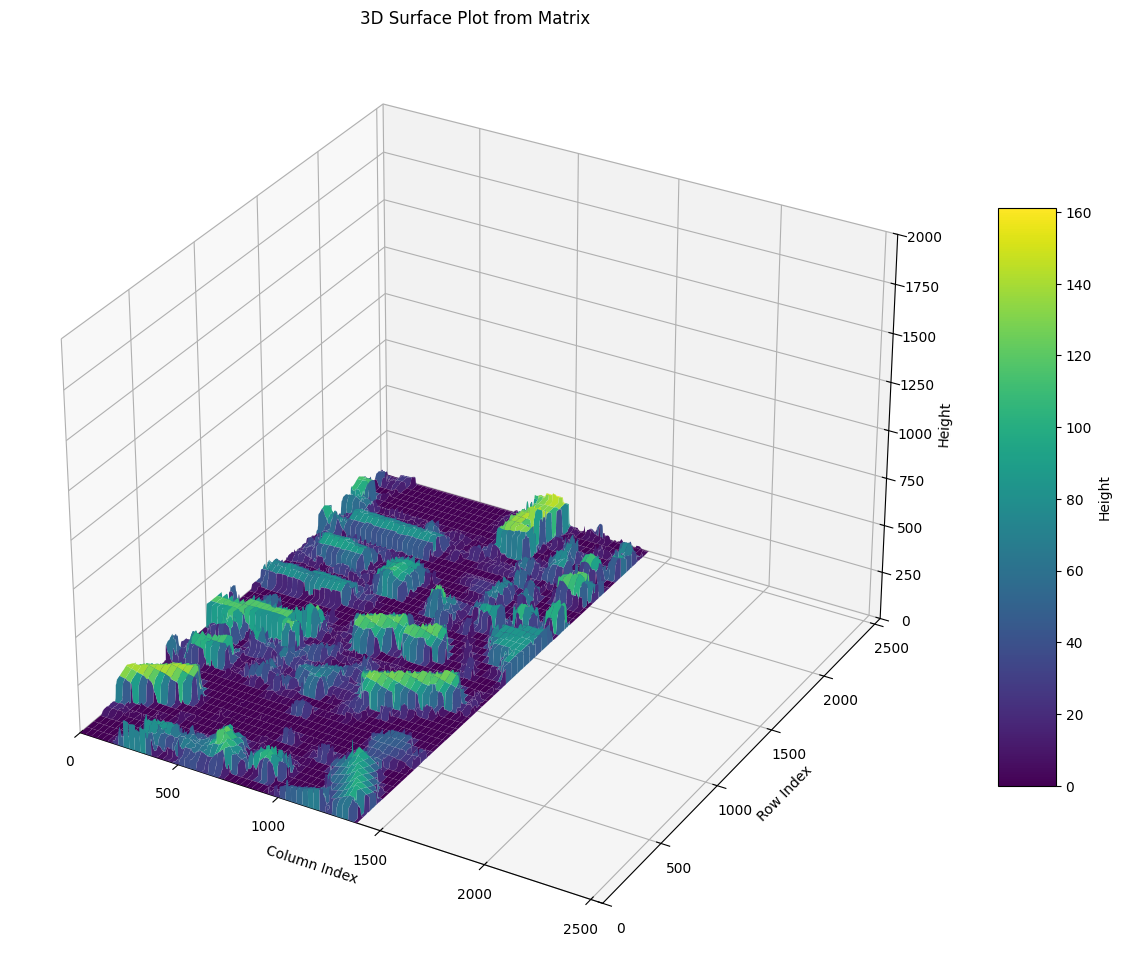

In [6]:
from matplotlib.colors import LogNorm
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

# Построение поверхности
surf = ax.plot_surface(X, Y, np.array(image), cmap='viridis', edgecolor='none')

# Добавление шкалы значений
cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Height')

# Настройка осей
ax.set_title("3D Surface Plot from Matrix")
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_zlabel("Height")
ax.set_xlim3d(0, 2555)
ax.set_ylim3d(0, 2555)
ax.set_zlim3d(0, 2000)

plt.show()

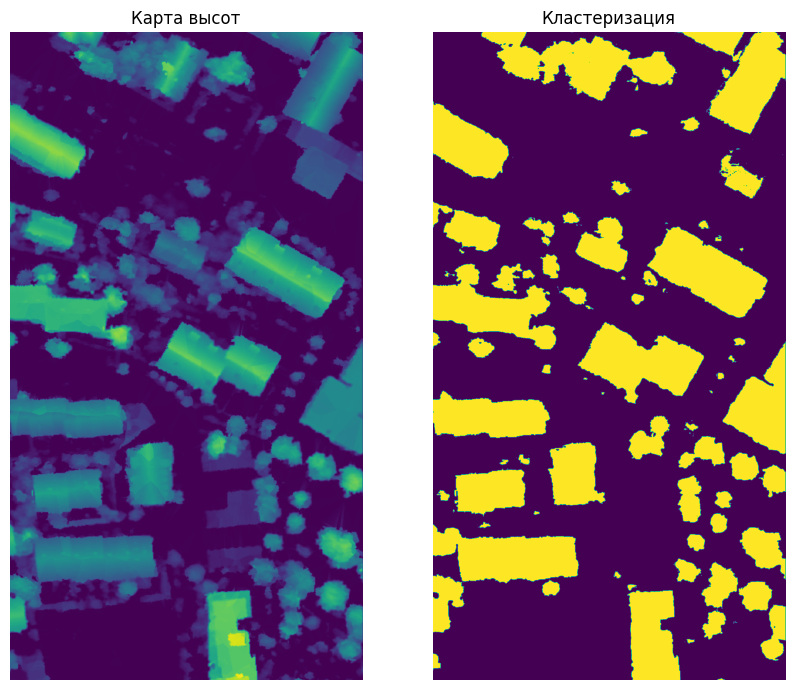

In [7]:
height_map = np.array(Image.open(vai))
pixels = height_map.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=0)  # Можно выбрать любое количество кластеров
kmeans.fit(pixels)

# Шаг 4: Преобразуем метки кластеров обратно в двумерное изображение
segmented_image = kmeans.labels_.reshape(height_map.shape)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(height_map)
axes[0].set(title='Карта высот')
axes[0].axis('off')
axes[1].imshow(segmented_image)
axes[1].set(title='Кластеризация');
axes[1].axis('off');

In [8]:
masked_height_map = height_map * segmented_image

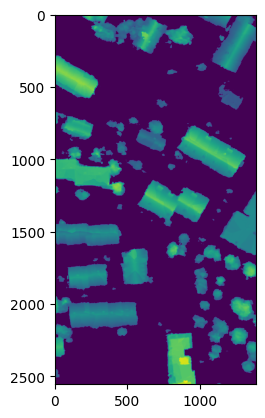

In [9]:
plt.imshow(masked_height_map)

In [10]:
coordinates = np.array(np.where(segmented_image == 1)).T
height_values = masked_height_map[segmented_image == 1]

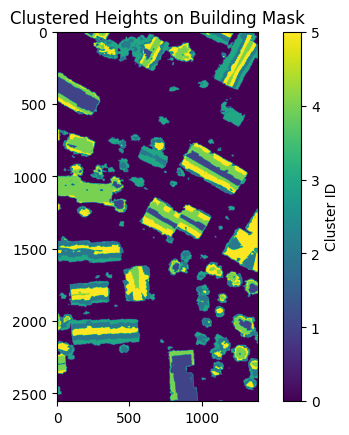

In [ ]:
coordinates = np.array(np.where(segmented_image == 1)).T
height_values = masked_height_map[segmented_image == 1]
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(height_values.reshape(-1, 1))
np.array([
    [1, 1, 1, 0, 0],
    [1, 1, 1, 0, 0],
    [1, 1, 1, 2, 2],
    [0, 0, 2, 2, 2],
    [0, 0, 2, 2, 2]
])
# Получаем метки кластеров для каждой точки
labels = kmeans.labels_

# Визуализируем результаты кластеризации на маске зданий
clustered_height_map = np.zeros_like(height_map)

# Помещаем значения кластеров обратно в картину (на маску зданий)
clustered_height_map[segmented_image == 1] = labels + 1  # Придаем каждому кластеру уникальный номер

# Визуализируем результат
plt.imshow(clustered_height_map, cmap='viridis')
plt.colorbar(label="Cluster ID")
plt.title("Clustered Heights on Building Mask")
plt.show()